In [62]:
import pandas as pd

writer_dir_name = 'data/geolife/runs'
log_dir_name = '[grid_origin_1000]_20240224-173505'
log_folder = writer_dir_name + '/' + log_dir_name
# best_model_path = log_folder + '/best_model.pth'
best_model_path = log_folder + '/best_train_model.pth'

config_df = pd.read_csv(log_folder + '/configuration.csv')
config_df.head()

,label_attribute,loss_method,loss_val_step,user_list_file,sample_s,sample_q,epoch,patience,batch_norm,day,week,y_timestep,length,train_list,val_list,test_list,train_columns
0,2,mse,3,extra_ratio.csv,2,2,5000,5,False,144,1008,72,2016,"['003', '030', '004', '039', '024']","['068', '038']","['068', '038']","['days', 'x', 'y', 'month', 'week', 'weekend',..."


In [63]:
# import pandas as pd

# writer_dir_name = 'data/geolife/runs'
# log_dir_name = '[grid_origin_1000]_20240222-162606'
# log_folder = writer_dir_name + '/' + log_dir_name
# # best_model_path = log_folder + '/best_model.pth'
# best_model_path = log_folder + '/best_train_model.pth'

# config_df = pd.read_csv(log_folder + '/configuration.csv')

data_dir = "data/geolife/Data/"
label_attribute = 2

sample_s = config_df['sample_s'][0]
sample_q = config_df['sample_q'][0]

args_epoch = config_df['epoch'][0]
args_patience = config_df['patience'][0]

gap_min = 12 # 1 min
gap = gap_min

day = config_df['day'][0]
week = config_df['week'][0]
y_timestep = config_df['y_timestep'][0]   #12 # must be less than length, 12 = 1 hour, 12 * 24 = 288 -> 1day
length = config_df['length'][0] # -> 4 weeks

train_list = config_df['train_list'][0]
validation_list = config_df['val_list'][0]
test_list = config_df['test_list'][0]

train_size = 0.4
validation_size = 0.1
batch_size = 1 # each user

## Test Phase
is_train = False

print(f"y_timestep: {y_timestep}, length: {length}")

y_timestep: 72, length: 2016


In [64]:
# TensorBoard 설정
import ast
from torch_time_het import TimeHetNet

import torch
from torch.utils.data import DataLoader
from torch_geolife_dateset import GeoLifeDataSet
from data.geolife.convert_minmax_location import LocationPreprocessor
import random

data_dir = "data/geolife/Data/"


train_list = config_df['train_list'][0]
validation_list = config_df['val_list'][0]
test_list = config_df['val_list'][0]#, '078']

test_list = ['068', '038']#, '039']#, '067']

print(f"train_list:      {train_list}")
print(f"validation_list: {validation_list}")
print(f"test_list:       {test_list}")

# Multi user
training_data   = GeoLifeDataSet(data_dir, train_list, sample_s, sample_q, length, y_timestep, gap, label_attribute)
validation_data = GeoLifeDataSet(data_dir, validation_list, sample_s, sample_q, length, y_timestep, gap, label_attribute)
test_data       = GeoLifeDataSet(data_dir, test_list, sample_s, sample_q, length, y_timestep, gap, label_attribute)

# single user
# training_data   = GeoLifeDataSet(data_dir, train_list, sample_s, sample_q, length, y_timestep, gap, label_attribute, mode='train')
# validation_data = GeoLifeDataSet(data_dir, validation_list, sample_s, sample_q, length, y_timestep, gap, label_attribute, mode='valid')
# test_data       = GeoLifeDataSet(data_dir, test_list, sample_s, sample_q, length, y_timestep, gap, label_attribute, mode='valid')


train_dataloader      = DataLoader(training_data, batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_data, batch_size, shuffle=False)
test_dataloader       = DataLoader(test_data, batch_size, shuffle=False)

best_model = TimeHetNet(dims_inf = ast.literal_eval("[32,32,32]"),
                        dims_pred = ast.literal_eval("[32,32,32]"), 
                        activation="relu", 
                        time=100,
                        batchnorm=False, 
                        block = str("gru,conv,conv,gru").split(","),
                        output_shape=[y_timestep, 2],
                        length=length)
best_model.load_state_dict(torch.load(best_model_path))


train_list:      ['003', '030', '004', '039', '024']
validation_list: ['068', '038']
test_list:       ['068', '038']


<All keys matched successfully>

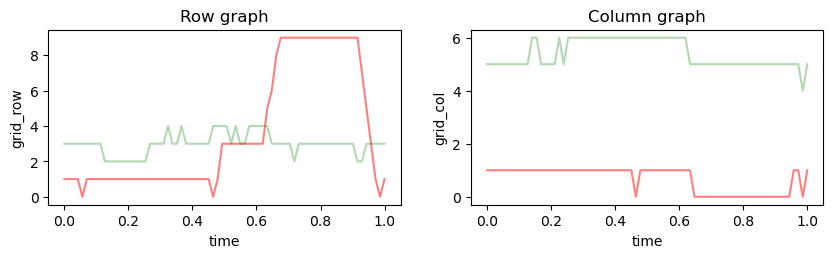

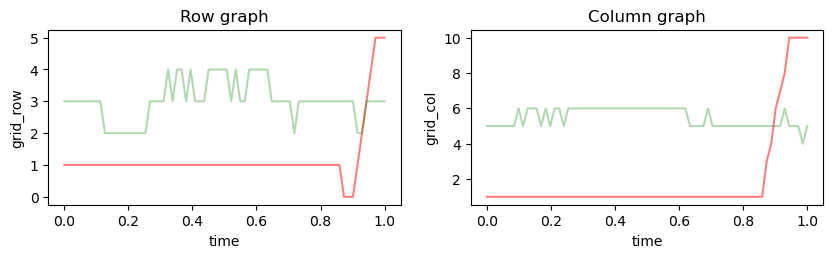

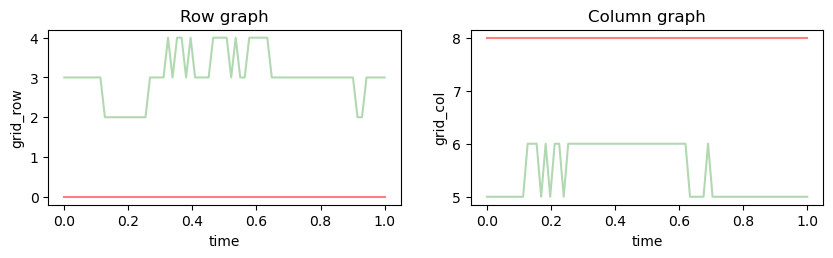

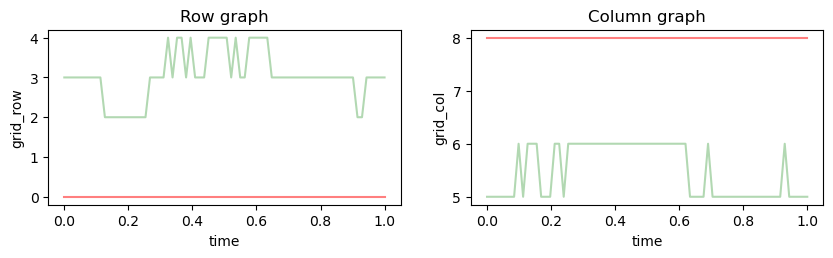

In [67]:
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class_probs = []
class_label = []
que_x_list = []

with torch.no_grad():
    for idx, test_data in enumerate(test_dataloader, 0):
        test_X, test_y = test_data
        if len(test_X) < 2:
            continue
        class_probs = []
        class_label = []
        que_x_list = []

        que_x, _, _ = test_X
        output = best_model(test_X)
        class_probs.append(output.type(torch.int64))
        class_label.append(test_y)
        # print(que_x.shape)
        que_x_list.append(que_x[:, :, -y_timestep:, 0])
        # print(que_x[:, :, -y_timestep:, :])
        
        test_probs = torch.cat(class_probs)
        test_label = torch.cat(class_label)
        test_que_x = torch.cat(que_x_list)

        # print(test_probs.shape)
        # print(test_label.shape)
        # print(test_que_x.shape)

        for user_idx in range(test_label.shape[0]):
            for test_idx in range(test_label.shape[1]):
                df = pd.DataFrame(data=test_que_x[user_idx][0], columns=['Time'])
                df_norm = MinMaxScaler().fit_transform(df)

                plt.figure(figsize=(10, 5))
                plt.subplot(2, 2, 1)
                plt.title('Row graph')
                # plt.scatter(df_norm, test_label[user_idx][test_idx][:, 0] , color='r', alpha=0.5)
                # plt.scatter(df_norm, test_probs[user_idx][test_idx][:, 0], color='g', alpha=0.3)
                plt.plot(df_norm, test_label[user_idx][test_idx][:, 0] , color='r', alpha=0.5)
                plt.plot(df_norm, test_probs[user_idx][test_idx][:, 0], color='g', alpha=0.3)
                plt.xlabel('time')
                plt.ylabel('grid_row')
                
                # fig_col = plt.figure(figsize=(5, 3))
                plt.subplot(2, 2, 2)
                plt.title('Column graph')
                # plt.scatter(df_norm, test_label[user_idx][test_idx][:, 1] , color='r', alpha=0.5)
                # plt.scatter(df_norm, test_probs[user_idx][test_idx][:, 1], color='g', alpha=0.3)
                plt.plot(df_norm, test_label[user_idx][test_idx][:, 1] , color='r', alpha=0.5)
                plt.plot(df_norm, test_probs[user_idx][test_idx][:, 1], color='g', alpha=0.3)
                plt.xlabel('time')
                plt.ylabel('grid_col')
                # plt.show() 


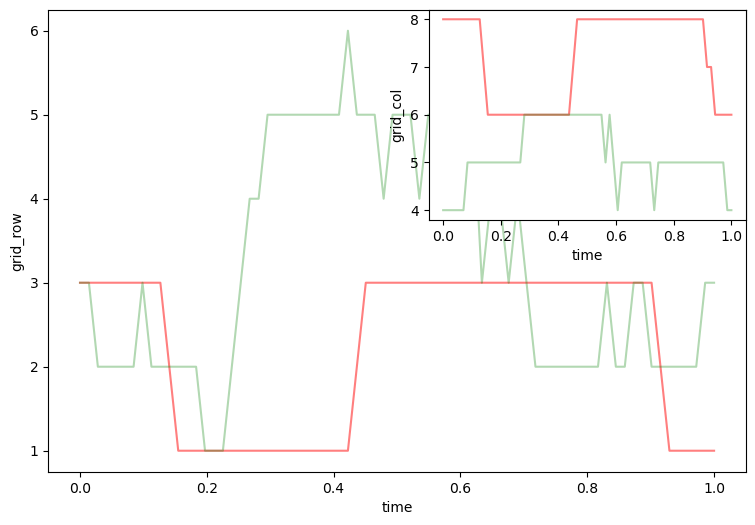

In [143]:
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

for idx in range(test_label.shape[0]):
    df = pd.DataFrame(data=test_que_x[idx][0], columns=['Time'])
    df_norm = MinMaxScaler().fit_transform(df)

    fig_row = plt.figure(figsize=(9, 6))
    ax_row = fig_row.add_subplot(111)
    ax_row.plot(df_norm, test_label[idx][0][:, 0] , color='r', alpha=0.5)
    ax_row.plot(df_norm, test_probs[idx][0][:, 0], color='g', alpha=0.3)
    ax_row.set_xlabel('time')
    ax_row.set_ylabel('grid_row')
    
    ax_col = fig_row.add_subplot(222)
    ax_col.plot(df_norm, test_label[idx][0][:, 1] , color='r', alpha=0.5)
    ax_col.plot(df_norm, test_probs[idx][0][:, 1], color='g', alpha=0.3)
    ax_col.set_xlabel('time')
    ax_col.set_ylabel('grid_col')


[[0.        ]
 [0.00955034]
 [0.01910067]
 [0.02865101]
 [0.03820135]
 [0.04775169]
 [0.05730203]
 [0.06685237]
 [0.07640271]
 [0.08595304]
 [0.09550338]
 [0.10505372]
 [0.11460406]
 [0.1241544 ]
 [0.13370473]
 [0.14325507]
 [0.15280541]
 [0.16235575]
 [0.17190609]
 [0.18145642]
 [0.19100676]
 [0.2005571 ]
 [0.21010744]
 [0.21965778]
 [0.22920812]
 [0.23875845]
 [0.24830879]
 [0.25785913]
 [0.26740947]
 [0.27695981]
 [0.28651015]
 [0.29606049]
 [0.30561082]
 [0.31516116]
 [0.3247115 ]
 [0.33426184]
 [0.34381218]
 [0.35336251]
 [0.36291285]
 [0.37246319]
 [0.38201353]
 [0.39156387]
 [0.4011142 ]
 [0.41066454]
 [0.42021488]
 [0.42976522]
 [0.43931556]
 [0.4488659 ]
 [0.45841624]
 [0.46796657]
 [0.47751691]
 [0.50855551]
 [0.51810585]
 [0.52765619]
 [0.53720653]
 [0.54675686]
 [0.5563072 ]
 [0.56585754]
 [0.57540788]
 [0.58495822]
 [0.59450855]
 [0.60405889]
 [0.61360923]
 [0.62315957]
 [0.63270991]
 [0.64226025]
 [0.65181059]
 [0.66136092]
 [0.67091126]
 [0.6804616 ]
 [0.69001194]
 [0.69

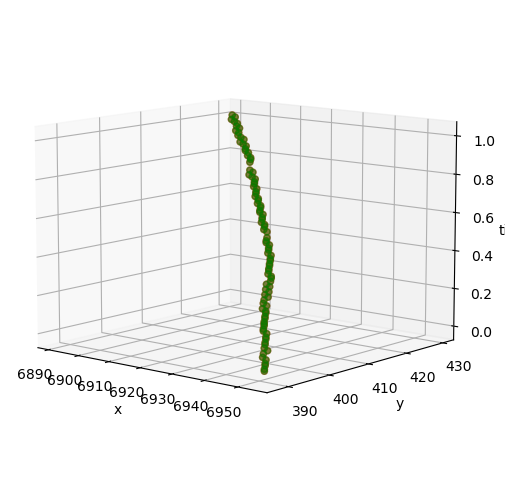

In [12]:
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# fig = plt.figure(figsize=(9, 6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x, y, z, color = 'r', alpha = 0.5)
# ax.scatter(x, z, y, color = 'g', alpha = 0.5) # y와 z축 swap

for idx in range(test_label.shape[0]):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=10, azim=-50)
    df = pd.DataFrame(data=test_que_x[idx][0], columns=['Time'])
    df_norm = MinMaxScaler().fit_transform(df)
    ax.scatter(test_label[idx][0][:, 0], test_label[idx][0][:, 1], df_norm,
               color='r', alpha=0.5)
    ax.scatter(test_probs[idx][0][:, 0], test_probs[idx][0][:, 1], df_norm, 
               color='g', alpha=0.5)
    print(df_norm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('time')

In [14]:
# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.functional as F

from torch import optim

import pandas as pd

class My_Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=None, name=None):
        super(My_Linear, self).__init__()
        self.Linear = nn.Linear(in_features, out_features, bias, device)
        self.name = name
    
    def forward(self, x):
        # print(f"My_Linear - X.shape: {x.shape}, name: {self.name}")
        x = self.Linear(x)
        return x

In [3]:
df = pd.read_csv('data/geolife/Data/000/csv/000.csv')
df.head(1)
df_test = df.iloc[:, :-2].copy()
df_test.head(1)

,latitude,longitude,what,altitude,days
0,39.984702,116.318417,0,492,39744.120185


In [4]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [21]:
X = ['latitude', 'longitude', 'altitude', 'days']
df_x = df_test[X].head(10).copy()
df_x = df_to_tensor(df_x)
print(df_x)
df_x = df_x.unsqueeze(axis=-1)
print(df_x)
df_x = df_x.sum(axis=2)
print(df_x)

tensor([[   39.9847,   116.3184,   492.0000, 39744.1211],
        [   39.9847,   116.3185,   492.0000, 39744.1211],
        [   39.9847,   116.3184,   492.0000, 39744.1211],
        [   39.9847,   116.3184,   492.0000, 39744.1211],
        [   39.9847,   116.3183,   492.0000, 39744.1211],
        [   39.9846,   116.3180,   493.0000, 39744.1211],
        [   39.9846,   116.3178,   493.0000, 39744.1211],
        [   39.9846,   116.3175,   496.0000, 39744.1211],
        [   39.9845,   116.3173,   500.0000, 39744.1211],
        [   39.9846,   116.3171,   505.0000, 39744.1211]])
tensor([[[   39.9847],
         [  116.3184],
         [  492.0000],
         [39744.1211]],

        [[   39.9847],
         [  116.3185],
         [  492.0000],
         [39744.1211]],

        [[   39.9847],
         [  116.3184],
         [  492.0000],
         [39744.1211]],

        [[   39.9847],
         [  116.3184],
         [  492.0000],
         [39744.1211]],

        [[   39.9847],
         [  116.3183

TypeError: expected np.ndarray (got builtin_function_or_method)

In [30]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_test, train_size=0.7, random_state=123)

X = ['latitude', 'longitude', 'altitude', 'days']
y = ['latitude', 'longitude']

row = 10
train_set = train_set.iloc[:row, :].copy()

train_X = df_to_tensor(train_set[X])
train_y = df_to_tensor(train_set[y])

model = My_Linear(4, 2)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
out_list = []
loss_train = 0.0
epochs = 10
for epoch in range(epochs):
    for input in train_X:
        outputs = model(input)
        print(outputs)
        loss = loss_fn(outputs, train_y)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    
    print(f"epoch:{epoch}, loss:{loss_train}")

tensor([ 14446.9902, -13492.7773], grad_fn=<AddBackward0>)
tensor([10405.8428, -9481.2021], grad_fn=<AddBackward0>)
tensor([ 6450.4893, -5513.5981], grad_fn=<AddBackward0>)
tensor([ 2502.3975, -1559.0204], grad_fn=<AddBackward0>)
tensor([-1504.5669,  2443.5837], grad_fn=<AddBackward0>)
tensor([-5533.4468,  6466.4849], grad_fn=<AddBackward0>)
tensor([-9534.4453, 10453.9717], grad_fn=<AddBackward0>)
tensor([-13421.3389,  14243.4980], grad_fn=<AddBackward0>)
tensor([-17012.7188,  17553.1680], grad_fn=<AddBackward0>)
tensor([-19572.9922,  19616.6016], grad_fn=<AddBackward0>)
epoch:0, loss:1346087930.0
tensor([-20963.5742,  20274.4062], grad_fn=<AddBackward0>)
tensor([-20957.9863,  19576.0664], grad_fn=<AddBackward0>)
tensor([-19623.0820,  17774.0215], grad_fn=<AddBackward0>)
tensor([-17550.9297,  15358.5293], grad_fn=<AddBackward0>)
tensor([-14911.8809,  12458.4883], grad_fn=<AddBackward0>)
tensor([-11804.6426,   9166.7256], grad_fn=<AddBackward0>)
tensor([-8373.7852,  5608.7310], grad_fn=

/home/shkoma/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [29]:
train_y

tensor([[ 31.1155, 121.0488],
        [ 40.0045, 116.3137],
        [ 39.9892, 116.2729],
        [ 40.0039, 116.3243],
        [ 40.1208, 116.2123],
        [ 39.9370, 116.3205],
        [ 39.8730, 116.4328],
        [ 39.9940, 116.3268],
        [ 39.9919, 116.3317],
        [ 39.9084, 116.3674]])